# $\color{blue}{\text{Data-driven Spatial Branch-and-bound }}$

To install the pyDDSBB package, use the following.

The code can be directly installed from github using the following command:

    pip install git+git://github.com/DDPSE/PyDDSBB/
    
The package can be updated from github using the following command:

    pip install update git+git://github.com/DDPSE/PyDDSBB/


Below you can find the examples for :

1. Box-constrained problem
2. Black-box equation-constrained problem
3. Grey-box equation-constrained problem


In [1]:
import PyDDSBB  ## import the pyDDSBB package
import numpy as np

# $\color{royalblue}{\text{Box-constrained problem}}$ 
<br>$ min_\mathbf{x} f(\mathbf{x}) $ </br>
<br>$ s.t.  \mathbf{x_{lb}} \le \mathbf{x} \le \mathbf{x_{ub}} $ </br>
<br>$ \mathbf{x} \in \mathbf{R}^{N} $</br>

### Example:
<br>$ min_{x_1,x_2} 4x_1^2 + 2.1x_1^4+x_1^6/3+{x_1}{x_2}-4x_2^2+4x_2^4$ </br>
<br>$ s.t.  -3 \le x_1 \le 3$ </br>
<br>$       -2 \le x_2 \le 2$ </br>
<br> solution: global optimum = -1.0316 at [-0.08984, 0.71265] and [0.08984, 0.71265] </br>

In [2]:
def camel(x):
    return float(4*x[0]**2 - 2.1*x[0]**4 + x[0]**6/3 + x[0]*x[1] - 4*x[1]**2+ 4*x[1]**4)

### Step 1: Define the model 

In [3]:
model_bcp = PyDDSBB.DDSBBModel.Problem() ## Initialize the model
model_bcp.add_objective(camel, sense = 'minimize') ##  add objective function, default: minimize
model_bcp.add_variable(-3.,3.) ## add variabel bounds (must be float point)
model_bcp.add_variable(-2.,2.)
print('problem dimensionality : ' + str(model_bcp._dim))  ## Dimension is counted 

problem dimensionality : 2


### Step 2: Specify the solver options

Here are the options for the DDSBB solver:

    multifidelity: bool  
                   True to turn on multifidelity approach 
                   False to turn off multifidelity approach (default)
                   
    split_method: str
                  Methods to determine split point on one dimension
                  select from:
                  For all types of problems:
                        'equal_bisection' (default), 'golden_section' 
                  For constrained problems:
                        'purity', 'gini'
                        
    variable_selection: str
                  Methods to determine which dimension to be splitted on.
                  select from: longest_side (default, for all problems), svr_var_select (for all problem)
                               purity, gini (constrained problems)
                               
    underestimator_option: str
                  Underestimator type 
                  Default: Quadratic
                  
    stop_option: dict
                Stopping criteria 
                absolute_tolerance: float  (tolerance for gap between the lower and the upper bound)
                relative_tolerance: float  (tolerance for relative gap between the lower and the upper bound)
                                   = absolute_gap/|lower bound| if it is a minimization problem)
                minimum_bound: float (minimum bound distance on the input space to avoid cutting the search space too small)
                sampling_limit: int (maximum number of samples)
                time_limit: float (maximum run time (s))
                
    sense: str
           select from: minimize, maximize (inform the solver the direction of optimization)
           
    adaptive_sampling: function of level, dimension (method for adaptive sampling, can be a function of level, dimenion) 

### Step 3: optimize 

In [4]:
#initial number of samples = 23
bcp_solver = PyDDSBB.DDSBB(23, underestimator_option = 'Quadratic',split_method = 'equal_bisection', \
                           variable_selection = 'longest_side', multifidelity = False, \
                           stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, \
                                          'minimum_bound': 0.05, 'sampling_limit': 500, 'time_limit': 5000})

In [5]:
bcp_solver.optimize(model_bcp)
bcp_solver.print_result()
yopt_bcp = bcp_solver.get_optimum()  ### Get optimal solution 
xopt_bcp = bcp_solver.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_bcp))
print('xopt : ' + str(xopt_bcp))

absolute gap closed
Time elapsed: 4.51s
Current level: 8
Current node: 48
Number of samples used: 234
Current best upper bound :  -1.030478500910937
Current best lower bound :  -1.0413210796231074
Current absolute gap:  0.010842578712170425
Current best optimizer: [[-0.10366214  0.70637252]]
yopt : -1.030478500910937
xopt : [[-0.10366214  0.70637252]]


### Step 4: resume the search with more samples
    enlarge the total sampling limit to 1000

In [6]:
bcp_solver.resume({'sampling_limit': 1000})
bcp_solver.print_result()
yopt_bcp = bcp_solver.get_optimum()  ### Get optimal solution 
xopt_bcp = bcp_solver.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_bcp))
print('xopt : ' + str(xopt_bcp))

Resume search with new resources
absolute gap closed
Time elapsed: 4.75s
Current level: 9
Current node: 50
Number of samples used: 243
Current best upper bound :  -1.0310785546195536
Current best lower bound :  -1.033444818151406
Current absolute gap:  0.0023662635318524305
Current best optimizer: [[-0.08569434  0.72004867]]
yopt : -1.0310785546195536
xopt : [[-0.08569434  0.72004867]]


# $\color{royalblue}{\text{Black-box Equation-Constrained Problems}}$ 
<br>$ min_\mathbf{x} f(\mathbf{x}) $ </br>
<br>$ s.t.  \mathbf{x_{lb}} \le \mathbf{x} \le \mathbf{x_{ub}} $ </br>
<br>$ g(\mathbf{x}) \le 0 $</br>  
<br>$ \mathbf{x} \in \mathbf{R}^{N} $</br>
<br> $g(\mathbf{x})$ is unknown </br>

### Method:
1. Samples are labelled as 1. (feasible) and 0. (infeasible)
2. Node are pruned if it contains only infeasible samples or the local lower bound is higher than the global upper bound

### Example:
<br>$ min_{x_1,x_2} x_1 $ </br>
<br>$ s.t. 0.25x_1-0.0625(x_1^2+x_2^2)+0.5x_2 \le 1.0 $</br>
<br>$ 0.071428(x_1^2+x_2^2) - 0.42857(x_1 + x_2) \le -1.0$<br>
<br>$ 1 \le x_1 \le 5.5$ </br>
<br>$ 1 \le x_2 \le 5.5$ </br>
<br> solution: global optimum = 1.177 at [1.1771, 2.1771] </br>

In [7]:
def prob06(x):
    return x[0]
def prob06_cons(x):
    if 0.25*x[0] - 0.0625*x[0]**2 - 0.0625*x[1]**2 + 0.5*x[1] <= 1.0 and 0.0714285714285714*x[0]**2 + 0.0714285714285714*x[1]**2 - 0.428571428571429*x[0] -0.428571428571429*x[1] <= -1.0:
        return 1.
    else:
        return 0.

### Step 1: Define the model

In [8]:
model_blk = PyDDSBB.DDSBBModel.Problem()
model_blk.add_objective(prob06)
model_blk.add_unknown_constraint(prob06_cons)
model_blk.add_variable(1., 5.5)
model_blk.add_variable(1., 5.5)

### Step 2: Specify Solver

In [9]:
blk_solver = PyDDSBB.DDSBB(23, split_method = 'equal_bisection',
                           variable_selection = 'longest_side', multifidelity = False, \
                           stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, \
                                          'minimum_bound': 0.05, 'sampling_limit': 500, 'time_limit': 5000})

### Step 3: Optimize

In [10]:
blk_solver.optimize(model_blk)
blk_solver.print_result()
yopt_blk = blk_solver.get_optimum()  ### Get optimal solution 
xopt_blk = blk_solver.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_blk))
print('xopt : ' + str(xopt_blk))

absolute gap closed
Time elapsed: 6.65s
Current level: 13
Current node: 80
Number of samples used: 387
Current best upper bound :  1.2109375
Current best lower bound :  1.17578125
Current absolute gap:  0.03515625
Current best optimizer: [[1.2109375 2.125    ]]
yopt : 1.2109375
xopt : [[1.2109375 2.125    ]]


# $\color{royalblue}{\text{Grey-box Equation-Constrained Problem}}$ 

<br>$ min_\mathbf{x} f(\mathbf{x}) $ </br>
<br>$ s.t.  \mathbf{x_{lb}} \le \mathbf{x} \le \mathbf{x_{ub}} $ </br>
<br>$ g(\mathbf{x}) \le 0 $</br>  
<br>$ \mathbf{x} \in \mathbf{R}^{N} $</br>
<br> $g(\mathbf{x})$ is fully known or partially known </br>

### Methods:
1. Samples are labelled as 1. (feasible) and 0. (infeasible)
2. Feasibility-based bound tightening is implemented at root node to tighten the search space
3. Constraint-violation minimization problem is solved to check if a node is feasible


### Example:
<br>$ min_{x_1,x_2} x_1 $ </br>
<br>$ s.t. 0.25x_1-0.0625(x_1^2+x_2^2)+0.5x_2 \le 1.0 $ (known)</br>
<br>$ 0.071428(x_1^2+x_2^2) - 0.42857(x_1 + x_2) \le -1.0$ (unknown)<br>
<br>$ 1 \le x_1 \le 5.5$ </br>
<br>$ 1 \le x_2 \le 5.5$ </br>
<br> solution: global optimum = 1.177 at [1.1771, 2.1771] </br>

### Step 1: Define the model

In [11]:
model_gr = PyDDSBB.DDSBBModel.Problem()
model_gr.add_objective(prob06)
model_gr.add_unknown_constraint(prob06_cons)
model_gr.add_known_constraint('0.25*x0 - 0.0625*x0**2 - 0.0625*x1**2 + 0.5*x1 <= 1.0')
model_gr.add_variable(1., 5.5)
model_gr.add_variable(1., 5.5)

### Step 2: Specify the solver

In [12]:
gr_solver = PyDDSBB.DDSBB(23, split_method = 'equal_bisection', \
                          variable_selection = 'longest_side', multifidelity = False, \
                          stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, \
                                         'minimum_bound': 0.05, 'sampling_limit': 500, 'time_limit': 5000})

### Step 3: Optimize

In [13]:
gr_solver.optimize(model_gr)
gr_solver.print_result()
yopt_gr = gr_solver.get_optimum()  ### Get optimal solution 
xopt_gr = gr_solver.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_gr))
print('xopt : ' + str(xopt_gr))

xlb after FBBT:  [1. 1.]
xub after FBBT:  [5.5 5.5]
absolute gap closed
Time elapsed: 10.43s
Current level: 13
Current node: 70
Number of samples used: 333
Current best upper bound :  1.2109375
Current best lower bound :  1.17578125
Current absolute gap:  0.03515625
Current best optimizer: [[1.2109375 2.125    ]]
yopt : 1.2109375
xopt : [[1.2109375 2.125    ]]


### Solve it as a glass-box problem 

In [14]:
model_gr.add_known_constraint('0.0714285714285714*x0**2 + 0.0714285714285714*x1**2 - 0.428571428571429*x0 -0.428571428571429*x1 <= -1.0')

In [15]:
gr_solver = PyDDSBB.DDSBB(23, split_method = 'equal_bisection', \
                          variable_selection = 'longest_side', multifidelity = False, \
                          stop_option = {'absolute_tolerance': 0.05, 'relative_tolerance': 0.01, 
                                         'minimum_bound': 0.05, 'sampling_limit': 500, 'time_limit': 5000})
gr_solver.optimize(model_gr)
gr_solver.print_result()
yopt_gr = gr_solver.get_optimum()  ### Get optimal solution 
xopt_gr = gr_solver.get_optimizer() ### Get optimizer
print('yopt : ' + str(yopt_gr))
print('xopt : ' + str(xopt_gr))

xlb after FBBT:  [1.17712428 1.        ]
xub after FBBT:  [5.00000003 4.82287572]
absolute gap closed
Time elapsed: 4.44s
Current level: 9
Current node: 30
Number of samples used: 140
Current best upper bound :  1.2082690406256973
Current best lower bound :  1.1771242763412135
Current absolute gap:  0.03114476428448376
Current best optimizer: [[1.20826904 2.15041346]]
yopt : 1.2082690406256973
xopt : [[1.20826904 2.15041346]]


# $\color{steelblue}{\text{Accessible Information}}$ 

In [16]:
import matplotlib.pyplot as plt

In [17]:
## Access Tree 
bcp_solver.Tree[0][0].print_node()

Node level:   0
Node number:  0
Local upper bound:  -0.6613868163165602
Local lower bound:  -49.50474635158223
Local gap: 48.84335953526567
Node active


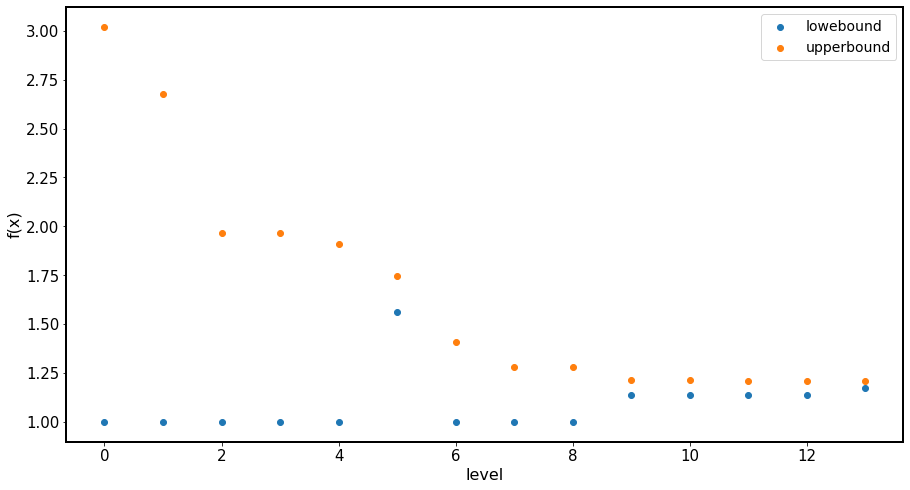

In [18]:
## Lowerbound and upperbound
plt.rc('axes', linewidth=2)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1 )
ax.scatter(range(len(blk_solver._lowerbound_hist)), blk_solver._lowerbound_hist)
ax.scatter(range(len(blk_solver._upperbound_hist)), blk_solver._upperbound_hist)
ax.set_xlabel('level', fontsize = 16)
ax.set_ylabel('f(x)', fontsize = 16)
ax.legend(['lowebound','upperbound'], fontsize = 14)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

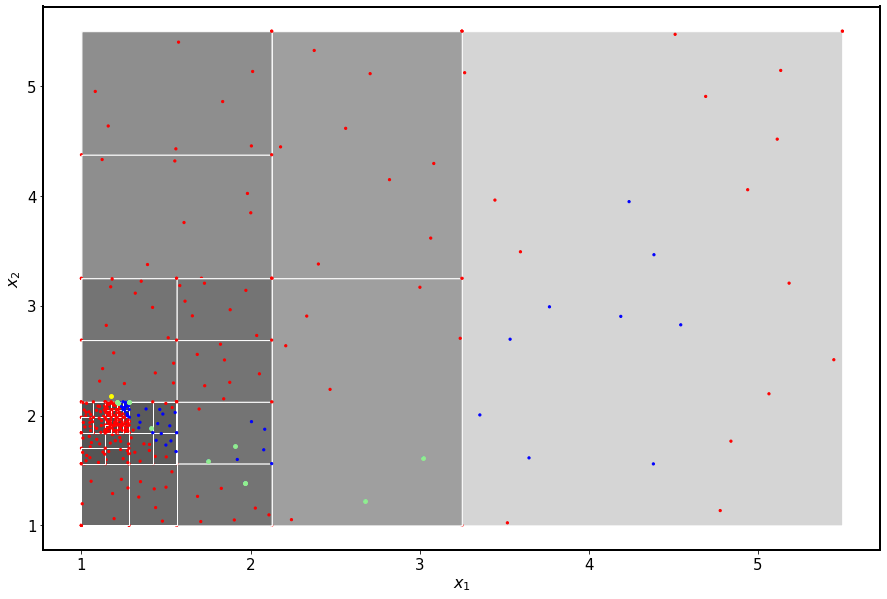

In [19]:
## Visualize the branch-and-bound process
plt.rc('axes', linewidth=2)
fig = plt.figure(figsize=(15,10))
ax2 = fig.add_subplot(1, 1, 1 )
for level in blk_solver.Tree.keys():               
    for node in blk_solver.Tree[level].values():
        shade1=np.arange(node.bounds[0,0], node.bounds[1,0],0.001)                    
        ax2.fill_between(shade1,node.bounds[1,1],node.bounds[0,1],facecolor=(str(1-level/(level+5))),edgecolors='w')  
        color = list(map(lambda x : 'red' if x == 0 else 'blue', node.label))
        ax2.scatter(node.x[:, 0 ], node.x[:, 1], s = 5, c = color)
for xopt in blk_solver._xopt_hist:
    try:
        ax2.scatter(xopt[0], xopt[1], s = 15, c = 'lightgreen')
    except:
        ax2.scatter(xopt[0, 0], xopt[0, 1], s = 15, c = 'lightgreen')
ax2.scatter(1.1771, 2.1771, s = 15, c = 'yellow')
ax2.set_xlabel('$x_1$', fontsize = 16)
ax2.set_ylabel('$x_2$', fontsize = 16)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

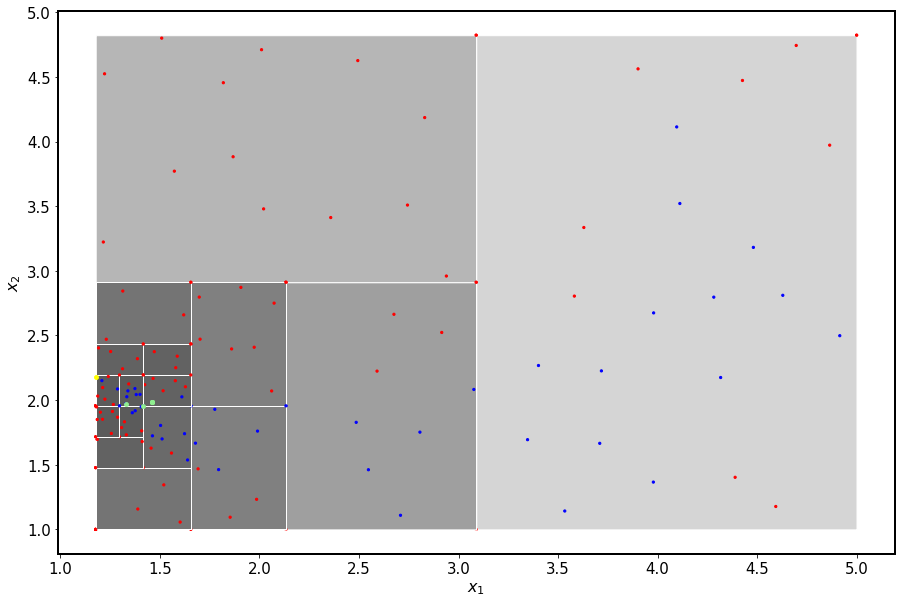

In [20]:
plt.rc('axes', linewidth=2)
fig = plt.figure(figsize=(15,10))
ax3 = fig.add_subplot(1, 1, 1 )
for level in gr_solver.Tree.keys():               
    for node in gr_solver.Tree[level].values():
        shade1=np.arange(node.bounds[0,0], node.bounds[1,0],0.001)                    
        ax3.fill_between(shade1,node.bounds[1,1],node.bounds[0,1],facecolor=(str(1-level/(level+5))),edgecolors='w')  
        color = list(map(lambda x : 'red' if x == 0 else 'blue', node.label))
        ax3.scatter(node.x[:, 0 ], node.x[:, 1], s = 5, c = color)
for xopt in gr_solver._xopt_hist:
    try:
        ax3.scatter(xopt[0], xopt[1], s = 15, c = 'lightgreen')
    except:
        ax3.scatter(xopt[0, 0], xopt[0, 1], s = 15, c = 'lightgreen')
ax3.scatter(1.1771, 2.1771, s = 15, c = 'yellow')
ax3.set_xlabel('$x_1$', fontsize = 16)
ax3.set_ylabel('$x_2$', fontsize = 16)
ax3.xaxis.set_tick_params(labelsize=15)
ax3.yaxis.set_tick_params(labelsize=15)